# Time Seires Analysis of the S&P 500 Intex Closing Price

time series steps:
    1. plot series
    2. eda
    3. test stationarity
    4. decompose time series
    5. model estimation
    6. Transform Data to Adjust for Non-Stationarity
    7. Test for Stationarity
    8. Build a Model 
    9. Forecast

1. How to explore your time series data for autocorrelation.
2. How to develop an autocorrelation model and use it to make predictions.
3. How to use a developed autocorrelation model to make rolling predictions.

“Time series is different from more traditional classification and regression predictive modeling problems.”

The S&P 500: https://en.wikipedia.org/wiki/S%26P_500_Index

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

In [2]:
import quandl
import warnings
import itertools


#arima modeling
from arima_utils import ad_fuller_test, plot_rolling_stats
from arima_utils import plot_acf_pacf, arima_gridsearch_cv

In [3]:
import math

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

from lstm_utils import get_raw_data
from lstm_utils import get_seq_model
from lstm_utils import get_seq_train_test
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## 1. Get Data

We would utilize the pandas_datareader library to get the required S&P 500 index history using Yahoo Finance databases.
For S&P 500 index, the ticker name is ^GSPC. 
The plot for closing price is depicted below.

In [4]:
STOCK_INDEX = '^GSPC'
sp_df = get_raw_data(STOCK_INDEX)
sp_df.head()

,High,Low,Open,Close,Volume,Adj Close
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3.991400e+09,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2.491020e+09,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4.972660e+09,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5.270680e+09,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4.389590e+09,1144.979980


In [5]:
sp_close_series = sp_df.Close 
sp_close_series.head()

2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
2010-01-08    1144.979980
Freq: D, Name: Close, dtype: float64

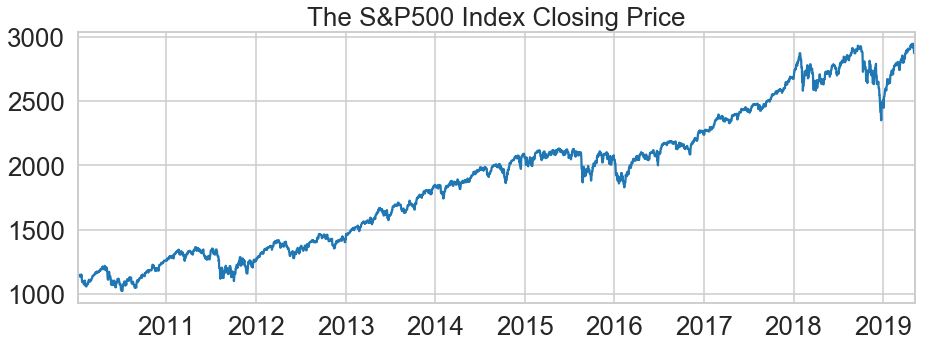

In [6]:
sp_close_series.plot(title = "The S&P500 Index Closing Price")

# ！！！补充differencing

## 2. Time Series Decomposition

Time series decomposition works by splitting a time series into three components: seasonality, trends and random fluctiation.
- Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.
- Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.
- Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

Visualizing our time-series data enables us to make inferences about important components, such as trend, seasonality, heteroskedasticity, and stationarity.

In [7]:
sp_close_df = pd.DataFrame(sp_close_series)
sp_close_df.reset_index(inplace=True)
sp_close_df.head(7)
#sp_close_df1 = sp_close_df.rename(index=str, columns={"index": "datetime"})
#sp_close_df1.head()

,index,Close
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980
5,2010-01-09,1144.979980
6,2010-01-10,1144.979980


The frequency of decomposition must be an interval, which 'may' repeat. So we have data with day-to day frequency and we are looking for a weekly repetition of behavior.
We would like to see every season trend and changing pattern of index closing price.

[5, 22, 65, 261]
Time decomposition: weekly, monthly, quaterly, yearly...


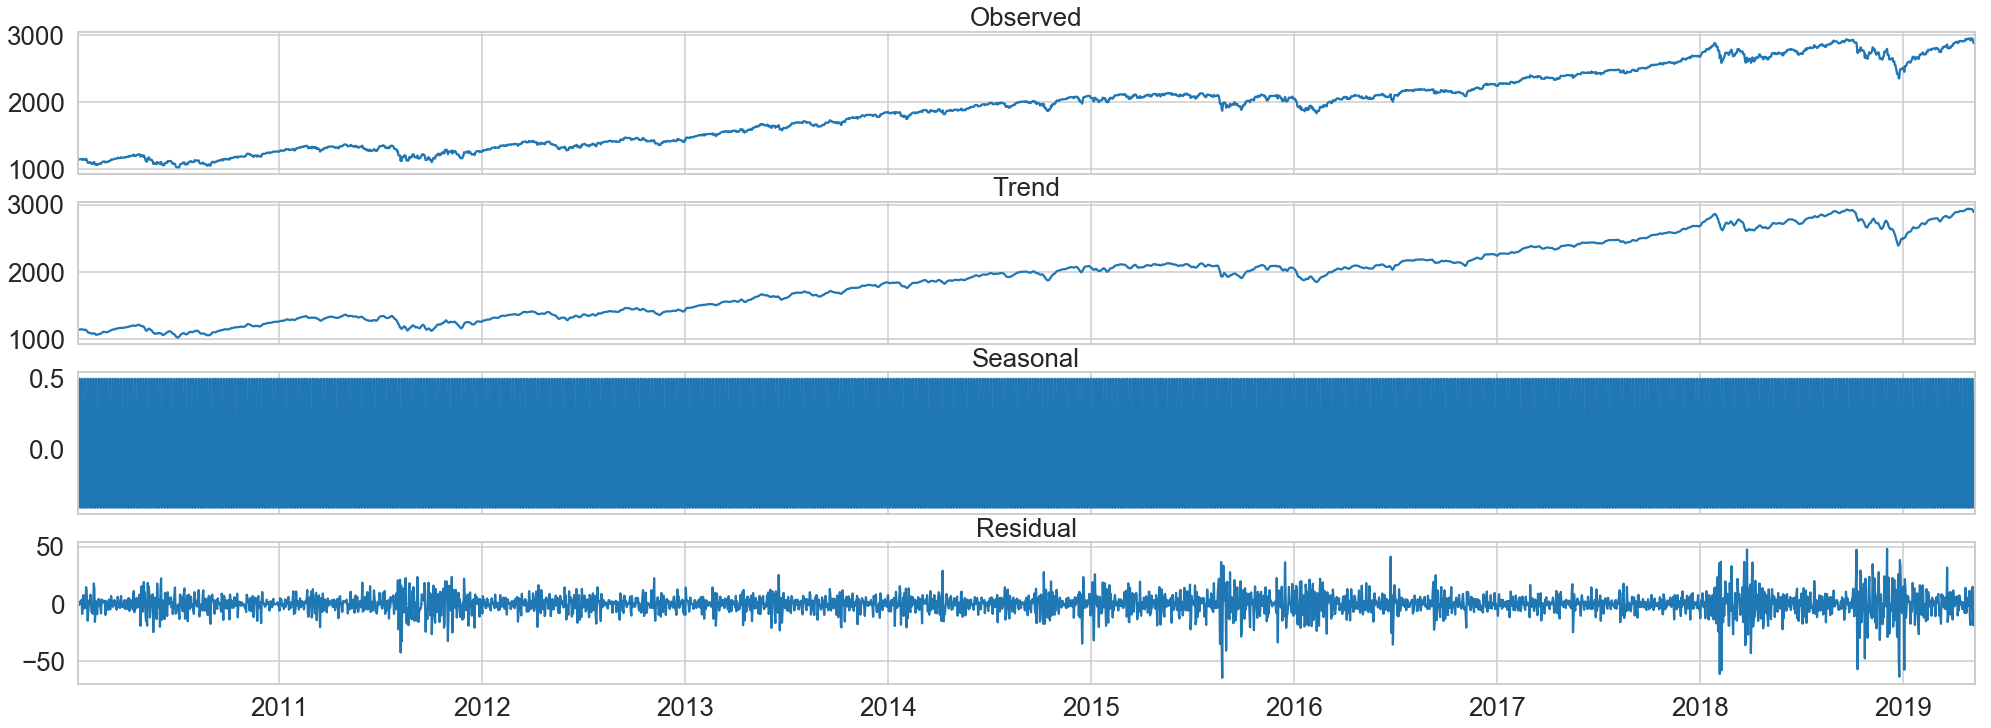

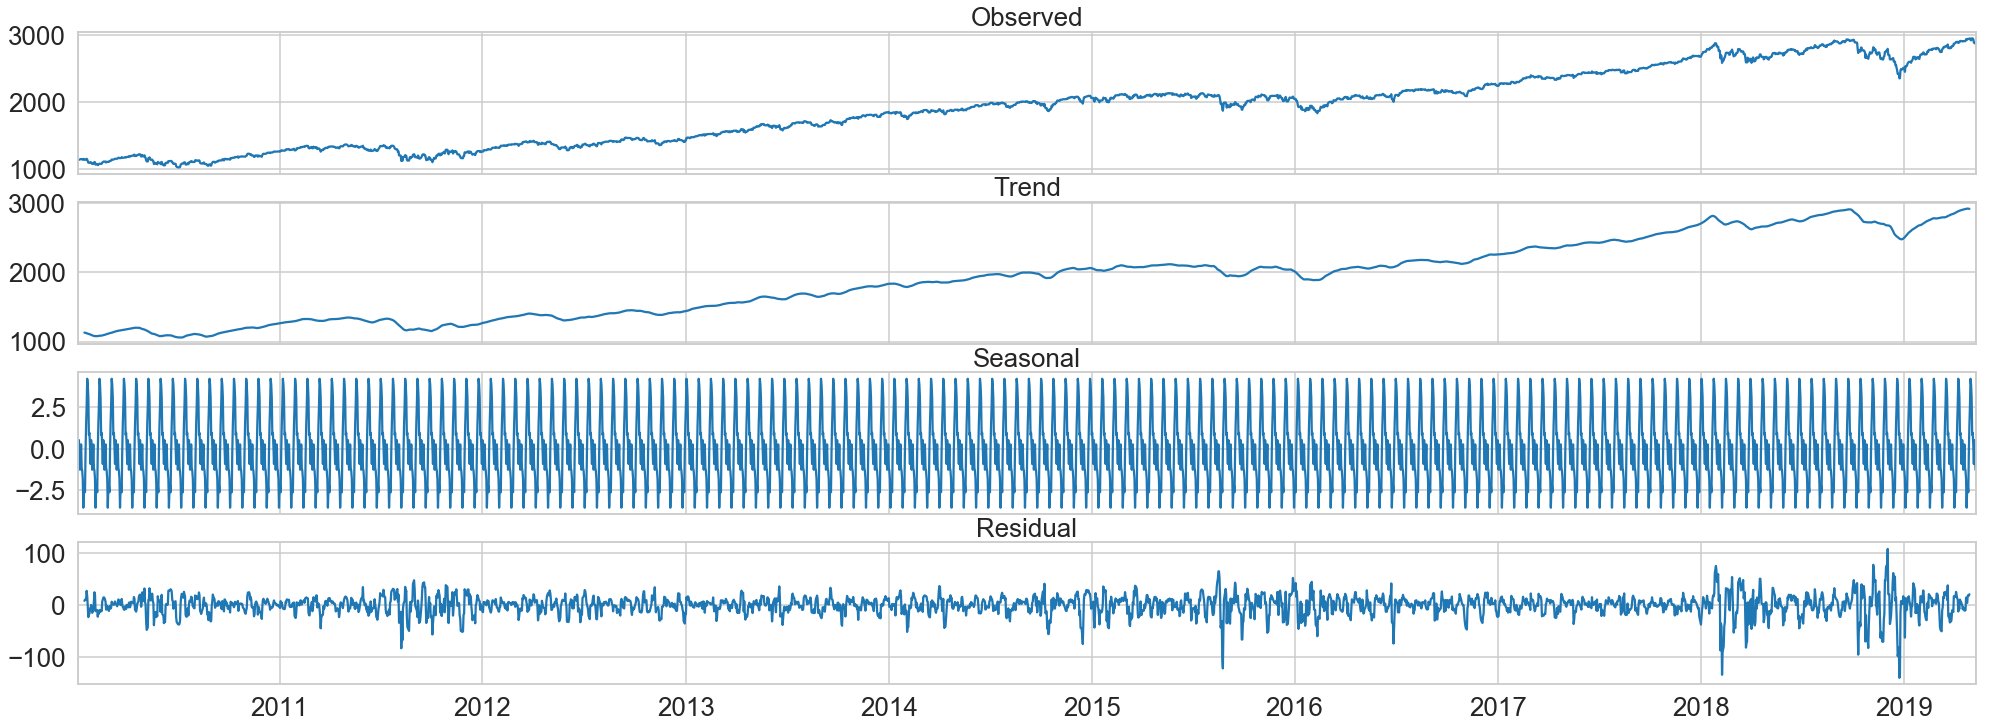

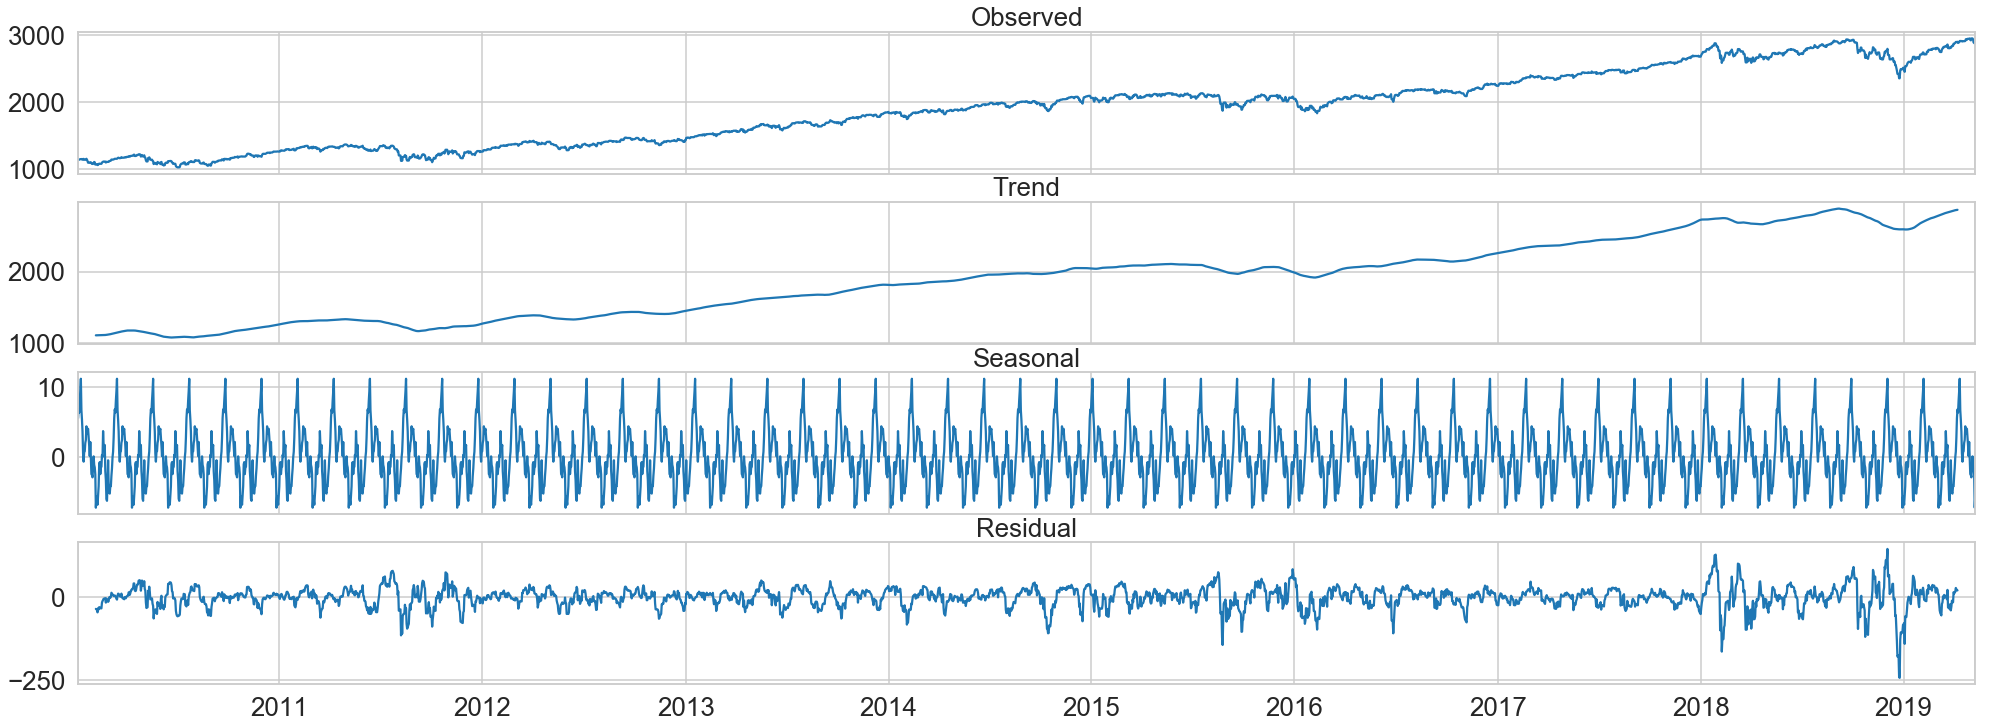

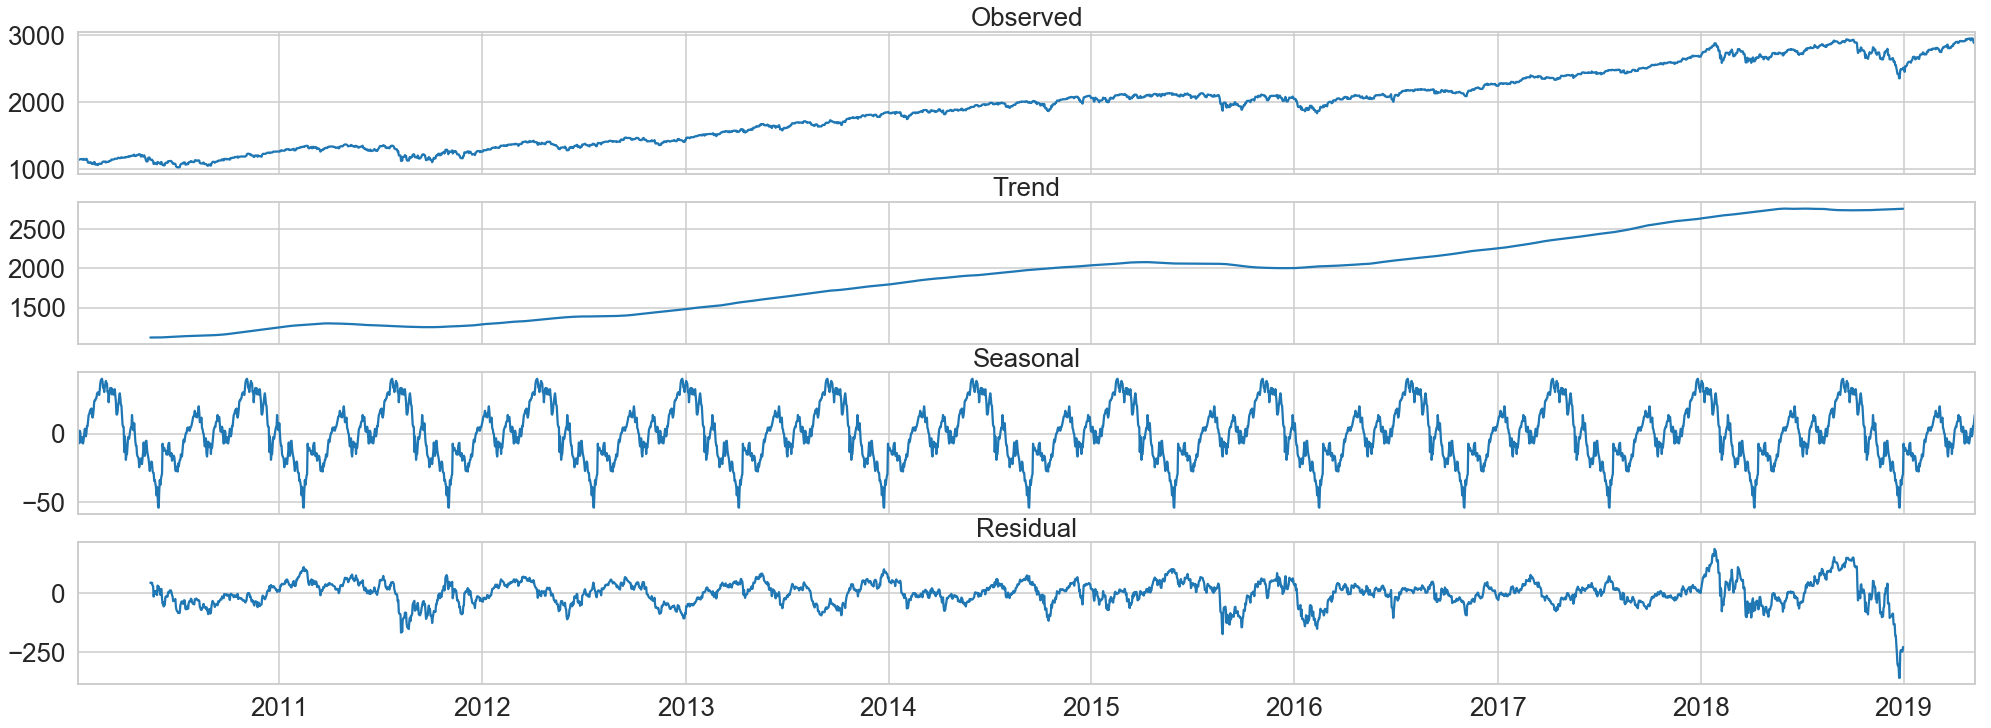

In [8]:
sp_close_df['date_of_transaction'] = pd.to_datetime(sp_close_df['index'])
sp_close_df.head(10)   

trading_days = 365 - 104
week = round(trading_days/52)
month = round(trading_days/12)
quater = round(trading_days/4)
year = trading_days

ts_close = pd.Series(sp_close_df.Close.values,
                    index=pd.date_range(
                                sp_close_df.date_of_transaction.min(),
                                sp_close_df.date_of_transaction.max(),
                                freq='D')
                     )
period_list = [week, month, quater, year]
print(period_list)
print("Time decomposition: weekly, monthly, quaterly, yearly...")

for i in period_list:
    deompose = seasonal_decompose(ts_close.interpolate(), freq = i)
    #deompose.plot()
      
    fig, axs = plt.subplots(4,1, sharex=True, figsize=(34,12))
    deompose.observed.plot(ax=axs[0], title = 'Observed')
    deompose.trend.plot(ax=axs[1], title = 'Trend')
    deompose.seasonal.plot(ax=axs[2], title = 'Seasonal')
    deompose.resid.plot(ax=axs[3], title = 'Residual')

## 3. Simple moving average and exponential smoothing based forecasting¶
     

### Simple Moving Average

moving average: https://en.wikipedia.org/wiki/Moving_average
??? how to select moving average window?

In [9]:
sp_close_df.head(10) 

,index,Close,date_of_transaction
0,2010-01-04,1132.989990,2010-01-04
1,2010-01-05,1136.520020,2010-01-05
2,2010-01-06,1137.140015,2010-01-06
3,2010-01-07,1141.689941,2010-01-07
4,2010-01-08,1144.979980,2010-01-08
5,2010-01-09,1144.979980,2010-01-09
6,2010-01-10,1144.979980,2010-01-10
7,2010-01-11,1146.979980,2010-01-11
8,2010-01-12,1136.219971,2010-01-12
9,2010-01-13,1145.680054,2010-01-13


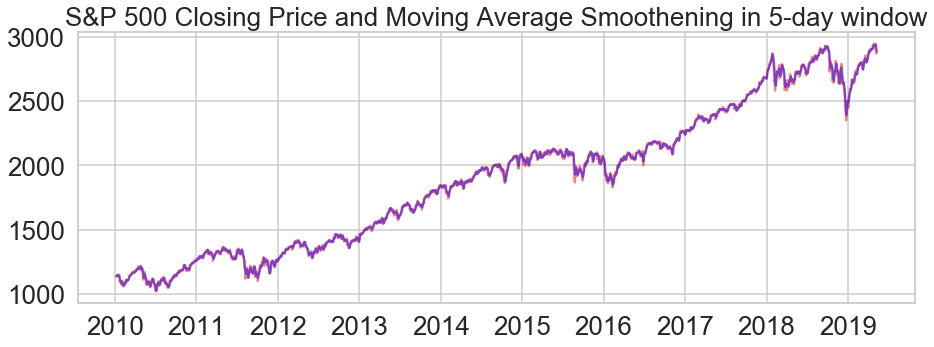

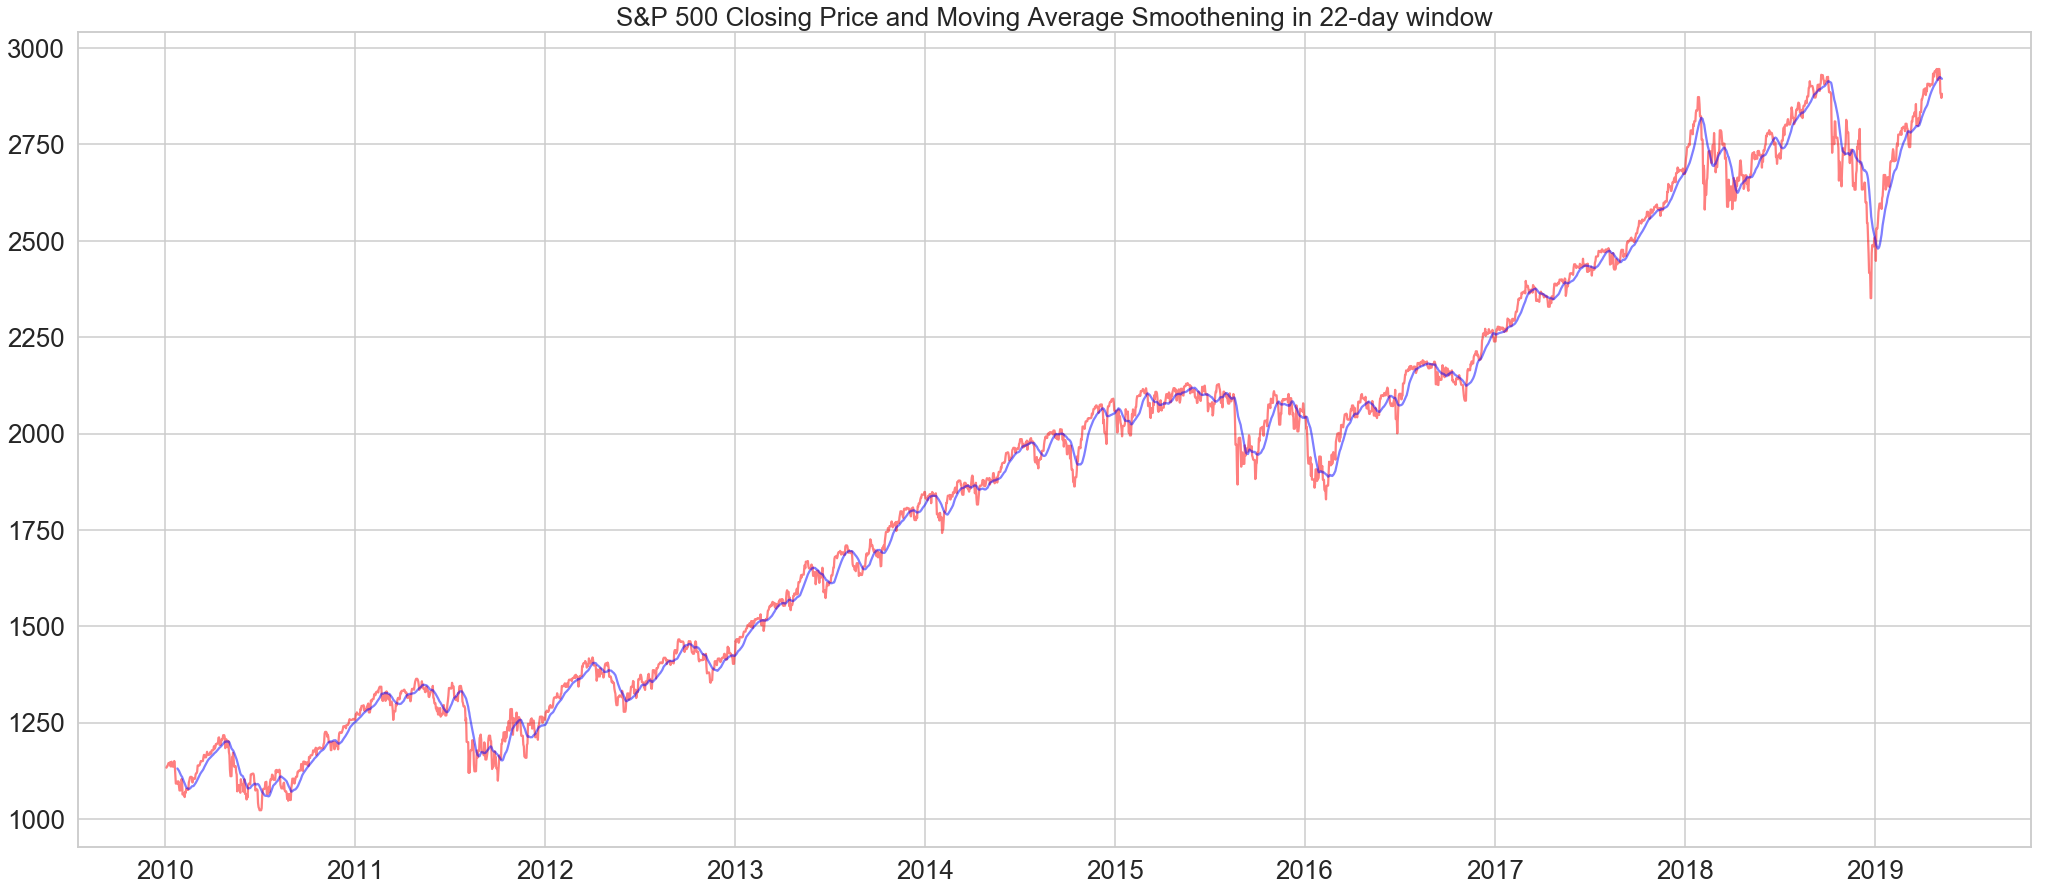

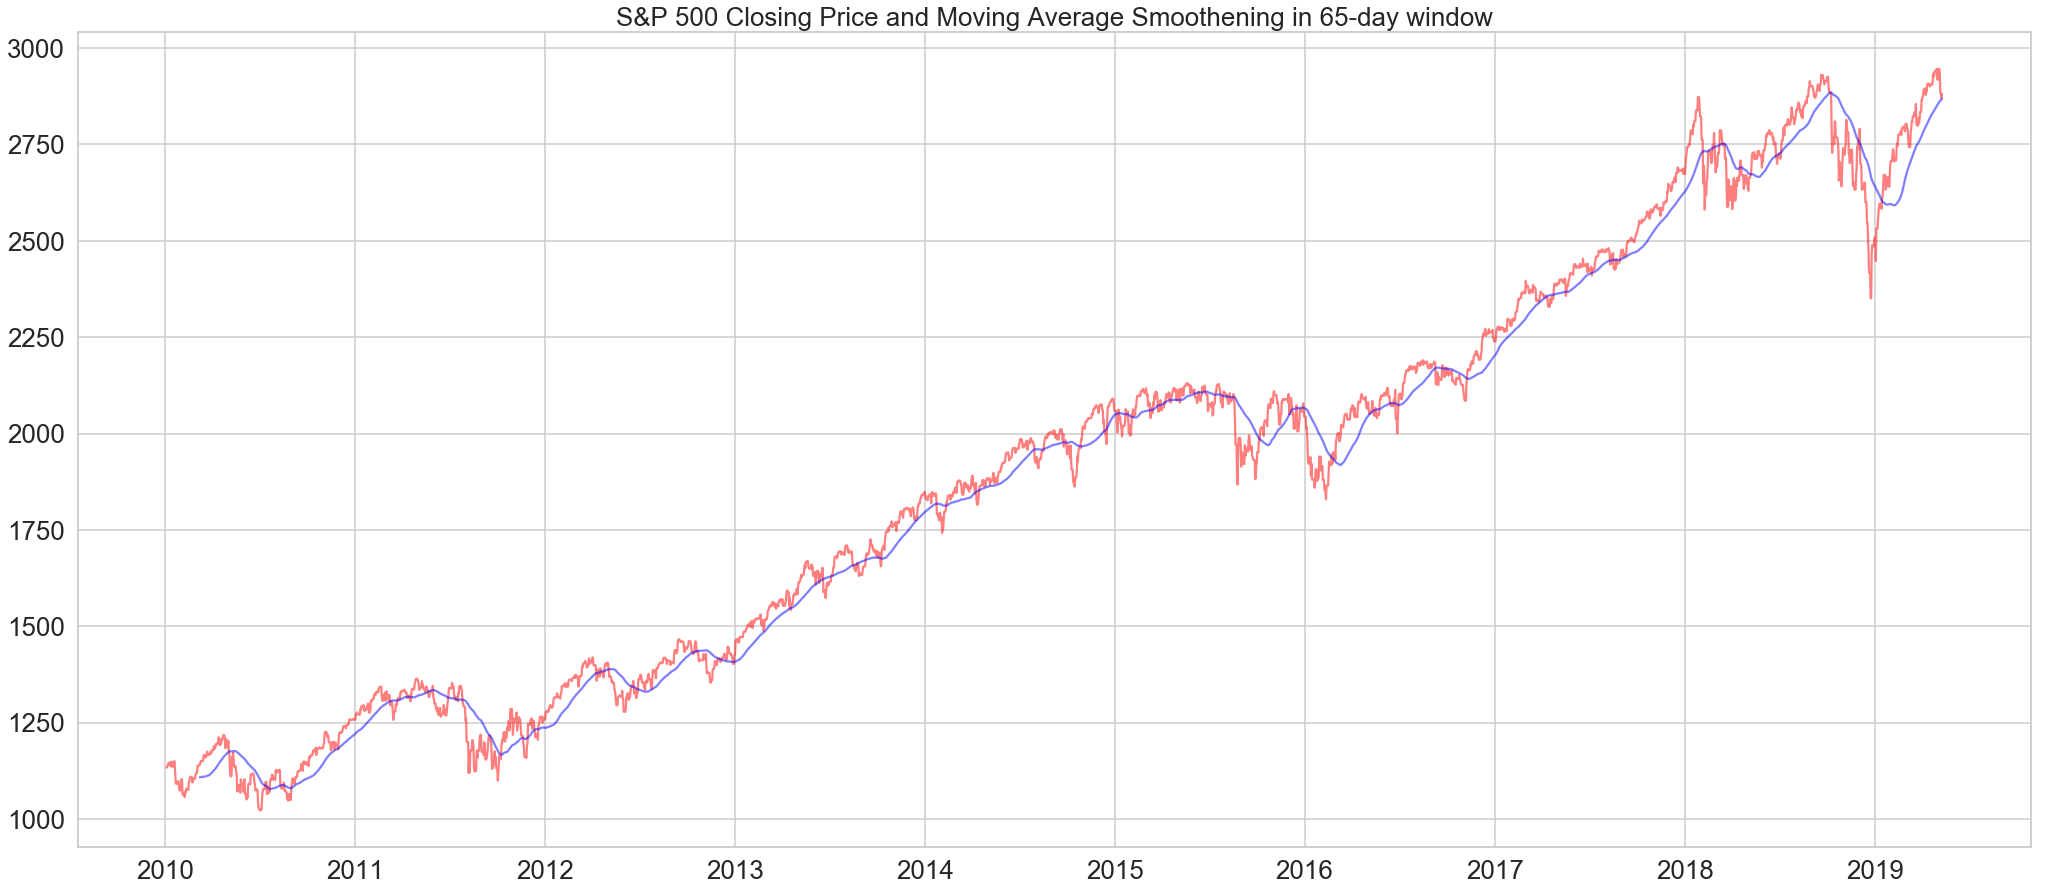

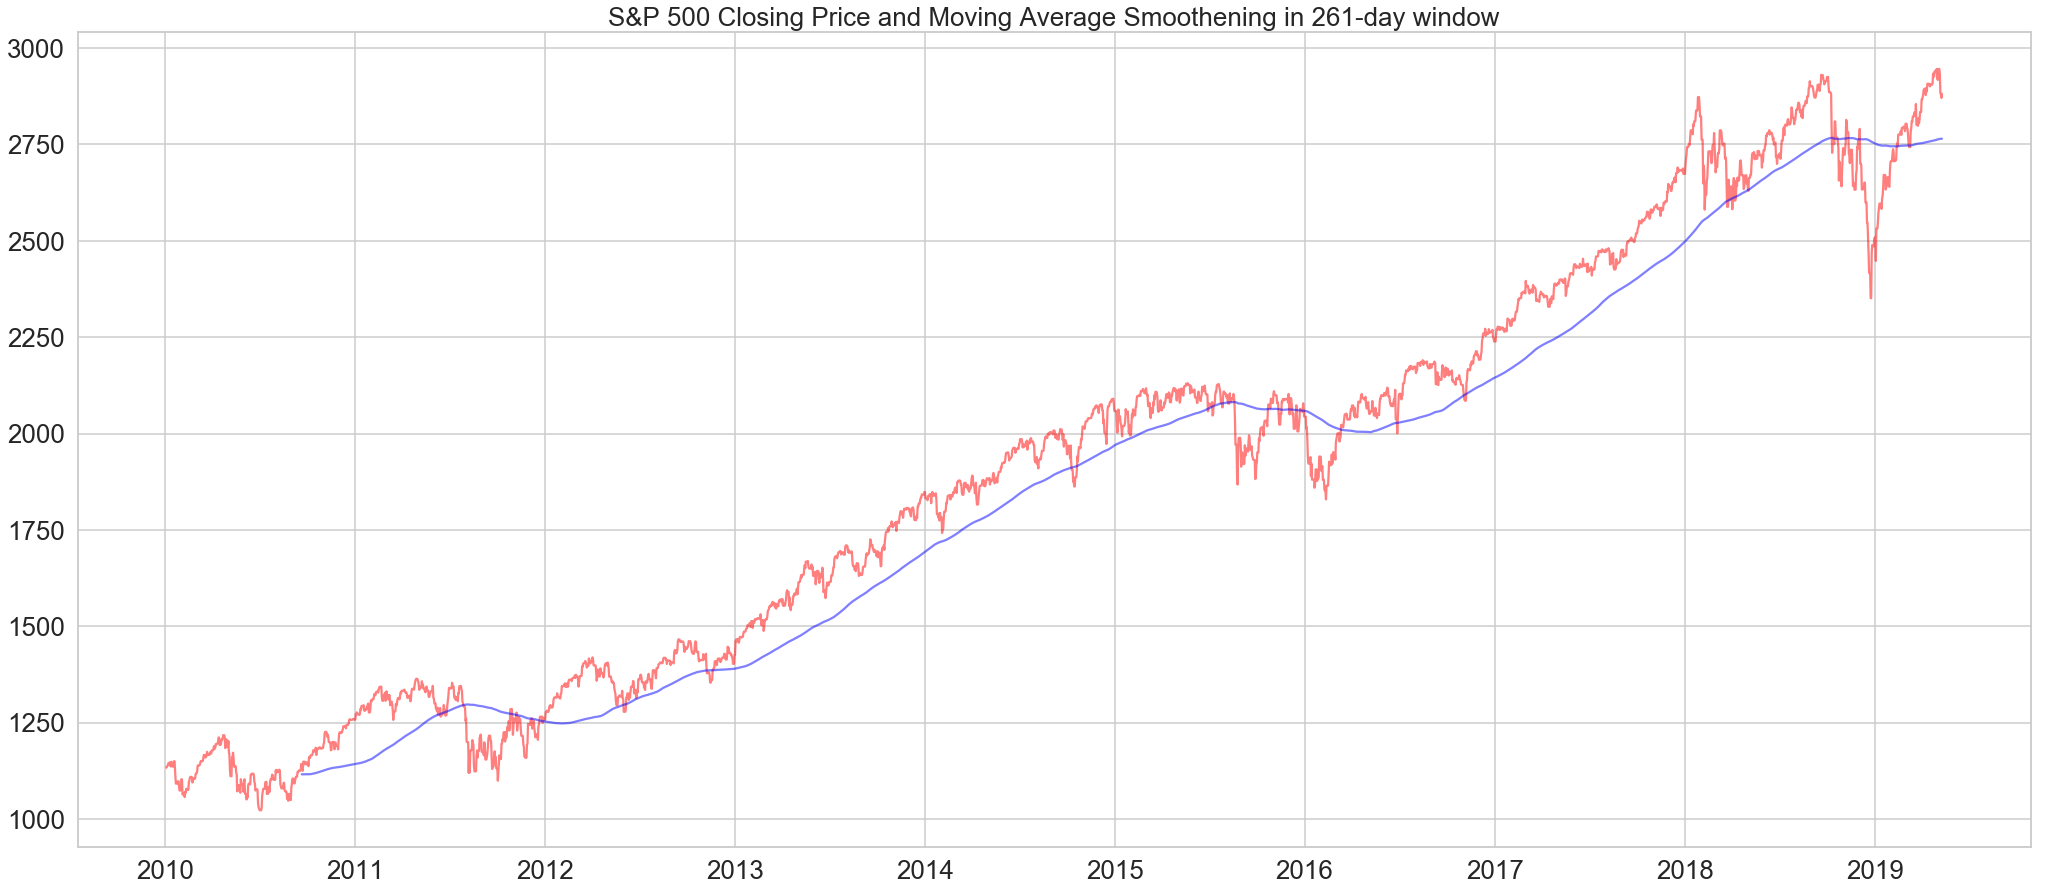

<Figure size 2520x1080 with 0 Axes>

In [10]:
for window in period_list:
    sp_close_df['moving_average'] = sp_close_df['Close'].rolling(window=window,
                                                        center=False).mean()
    #sp_close_df[['Close','moving_average']].head(10)
    #print(sp_close_df.head(5))
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.Close,'-',color='red',alpha=0.5)
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.moving_average, color='b', alpha=0.5)
    plt.title('S&P 500 Closing Price and Moving Average Smoothening in '+ str(window) + '-day window')
    plt.figure(figsize=(35,15))
    #plt.legend()

### Exponential Smoothing¶


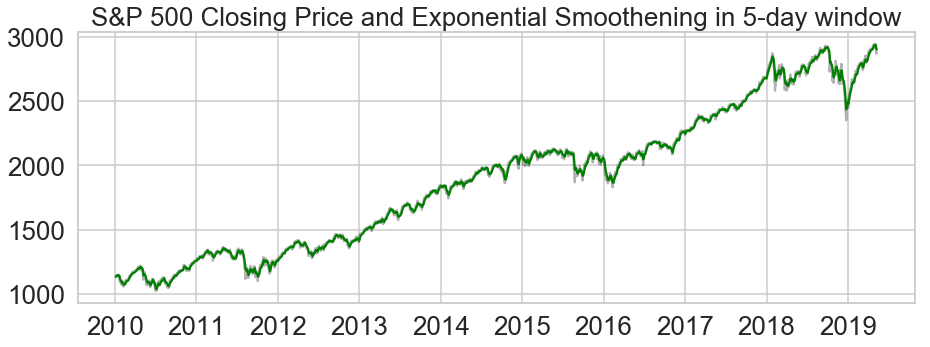

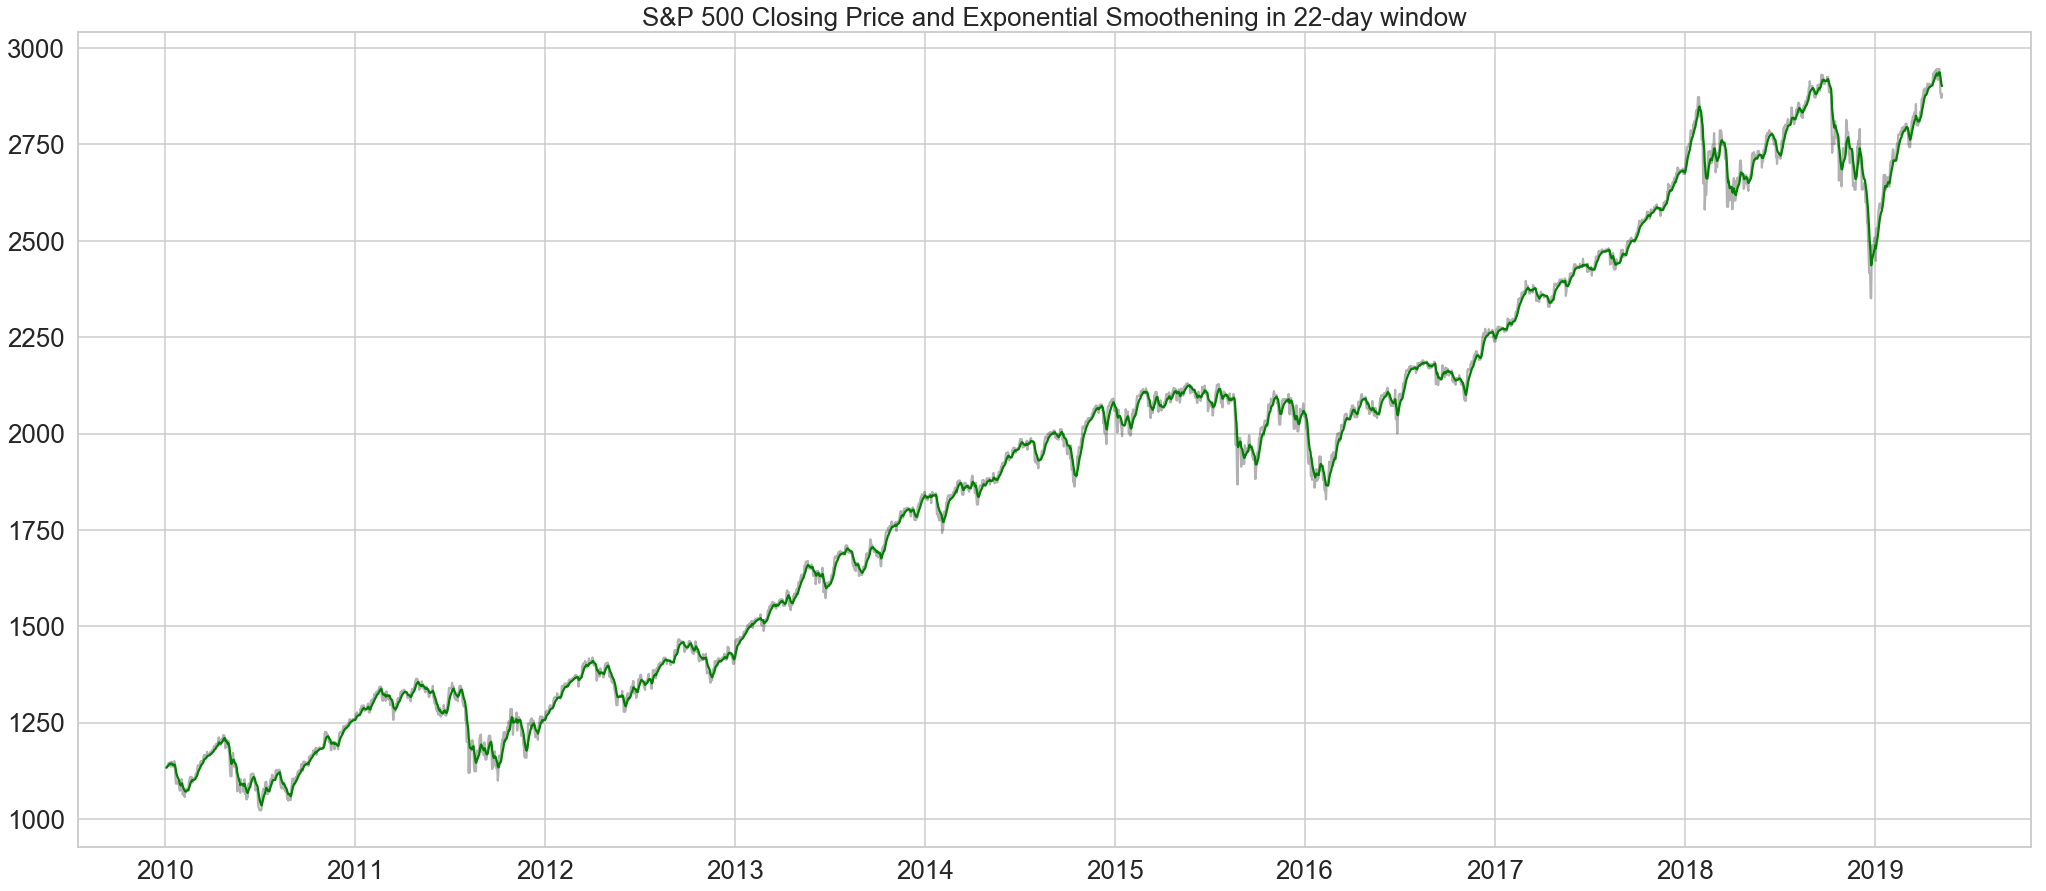

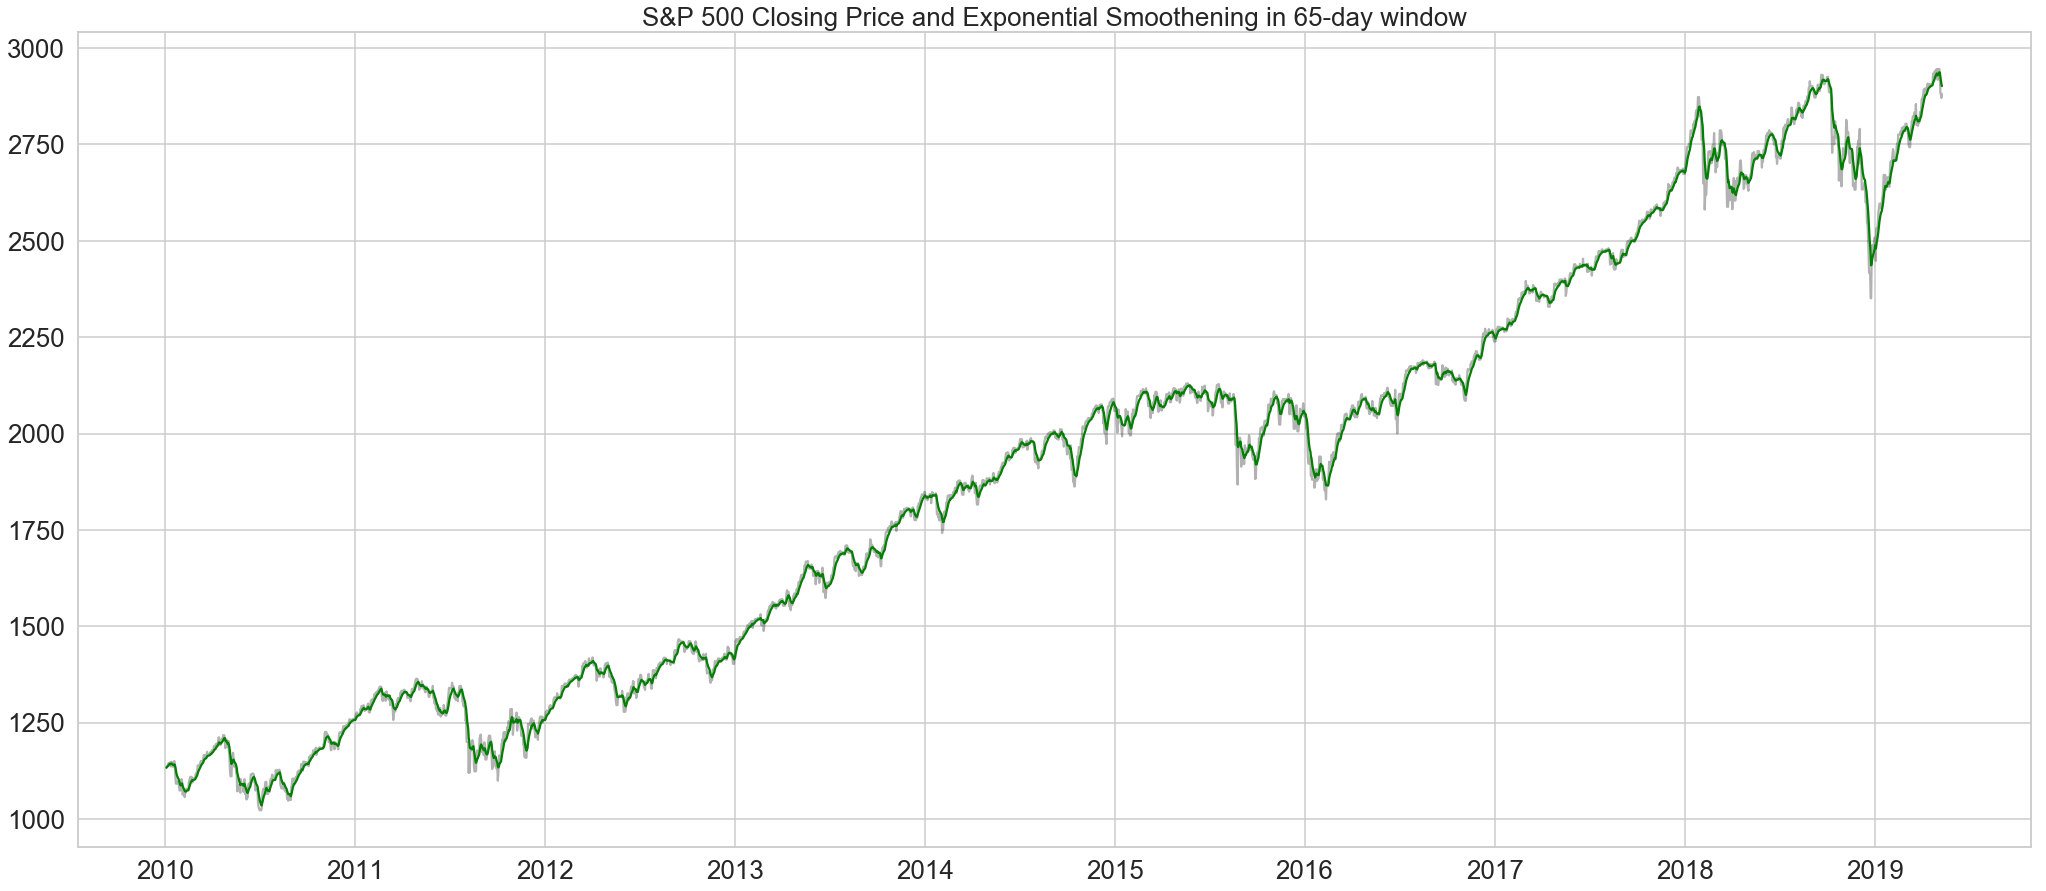

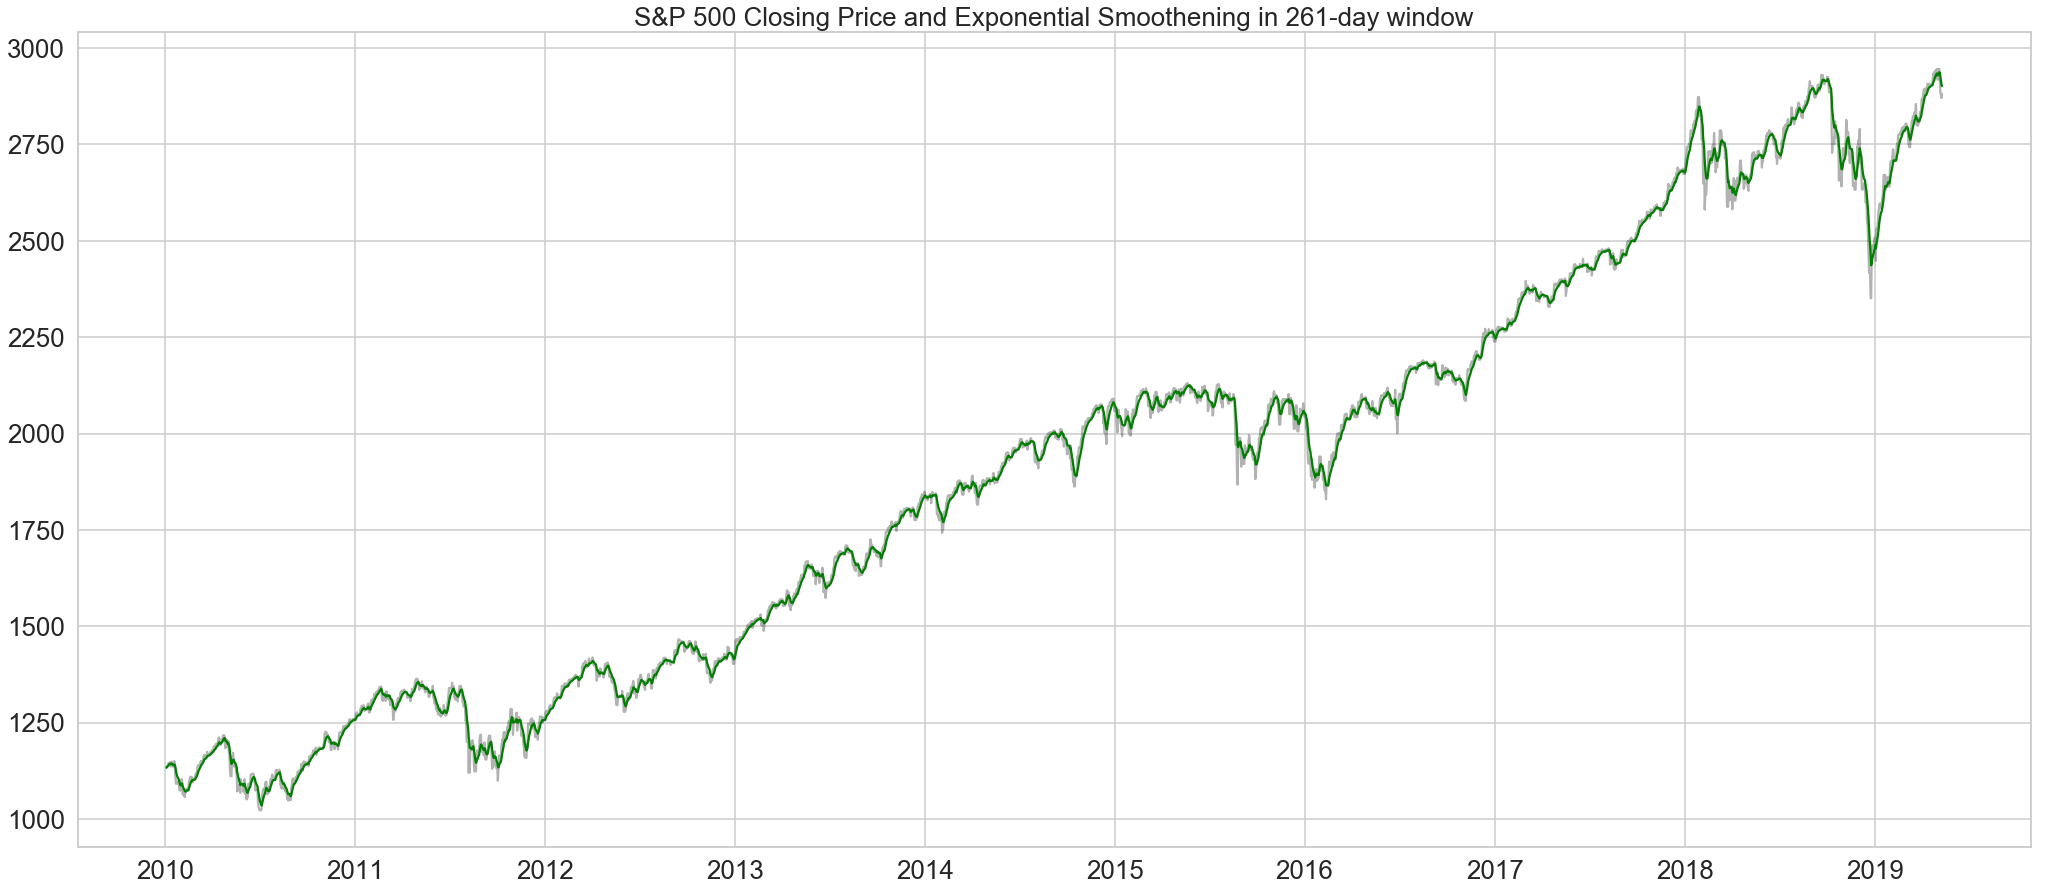

<Figure size 2520x1080 with 0 Axes>

In [11]:
for window in period_list:
    sp_close_df['ewma'] = sp_close_df['Close'].ewm(halflife=3,
                                            ignore_na=False,
                                            min_periods=0,
                                            adjust=True).mean()

    plt.plot(sp_close_df.date_of_transaction, sp_close_df.Close,'-',color='black',alpha=0.3)
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.ewma,color='g')
    plt.title('S&P 500 Closing Price and Exponential Smoothening in '+ str(window) + '-day window')
    plt.figure(figsize=(35,15))

## 4. Test for Stationarity

We are going to make use of Augmented Dickey Fuller test to check the series for stationarity, since stationarity is one of the primary assumptions of ARIMA models.

### Dickey Fuller Test for Stationarity

In [24]:
sp_close_arima = pd.DataFrame(sp_close_series)
#sp_close_arima.reset_index(inplace=True)
sp_close_arima.head(7)

,Close
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980
2010-01-09,1144.979980
2010-01-10,1144.979980


Test Statistic                   -0.143678
p-value                           0.944911
#Lags Used                        7.000000
Number of Observations Used    3406.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


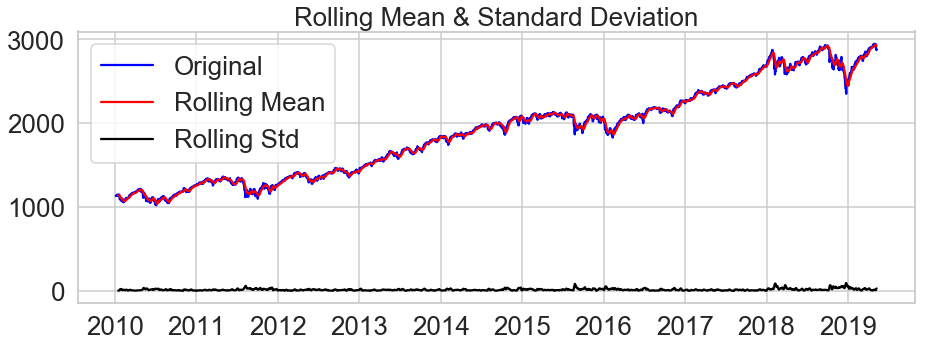

In [25]:
# Original Series
ad_fuller_test(sp_close_arima.Close)
plot_rolling_stats(sp_close_arima.Close)

Result Interpretation:
The test statistic of AD Fuller test (-0.184719) is greater than the critical value(s), hence we fail to reject the null hypothesis. The series data is non-stationary and has a unit root.

### Log Transformation

Test Statistic                   -0.654210
p-value                           0.858256
#Lags Used                        7.000000
Number of Observations Used    3406.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


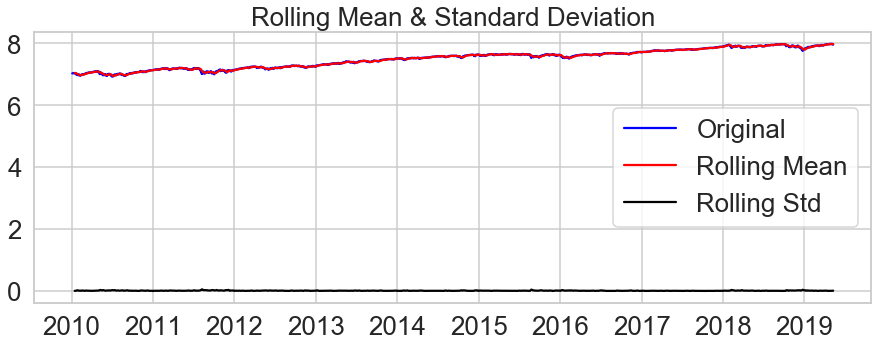

In [26]:
sp_close_arima_df = sp_close_arima
log_series = np.log(sp_close_arima_df.Close)

ad_fuller_test(log_series)
plot_rolling_stats(log_series)

The series is non-stationary even after being log-transformed. 

### Log Differencing

"As discussed in the key concepts", differencing a series helps in achieving stationarity. 

In [27]:
# Using log series with a shift to make it stationary
log_series_shift = log_series - log_series.shift()
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]

Test Statistic                  -24.240302
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    3406.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


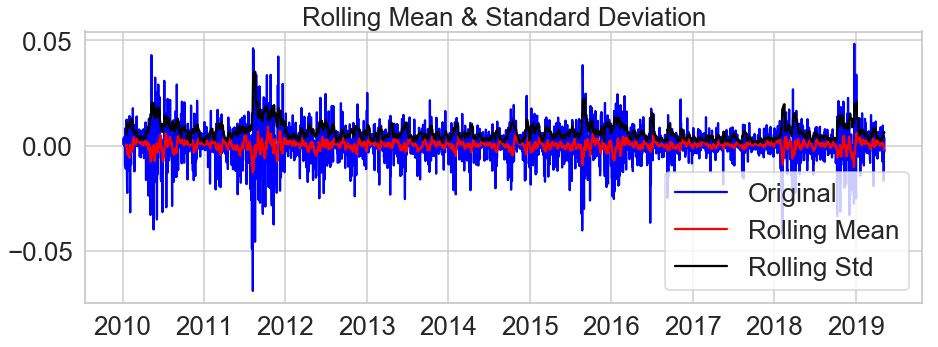

In [28]:
ad_fuller_test(log_series_shift)
plot_rolling_stats(log_series_shift)

The test statistic at -24.23 is lower than even 1% critical value, thus we reject the null hypothesis for AD Fuller test. 
We could use a log differenced series for ARIMA modeling of the SP500 data.

## 5. Model Estimation 

### ACF/ PACF
Diagnosing the ACF and PACF Plots of Our Time-Series Object
The ACF and PACF diagnosis is employed over a time-series to determine the order in which we are going to create our model using ARIMA modeling. Loosely speaking, a time series is stationary when its mean, variance, and autocorrelation remain constant over time.

These functions help us understand the correlation component of different data points at different time lags. Lag refers to the time difference between one observation and a previous observation in a dataset.

In [34]:
#plot_acf_pacf(sp_close_arima)

In [35]:
#plot_acf_pacf(log_series)

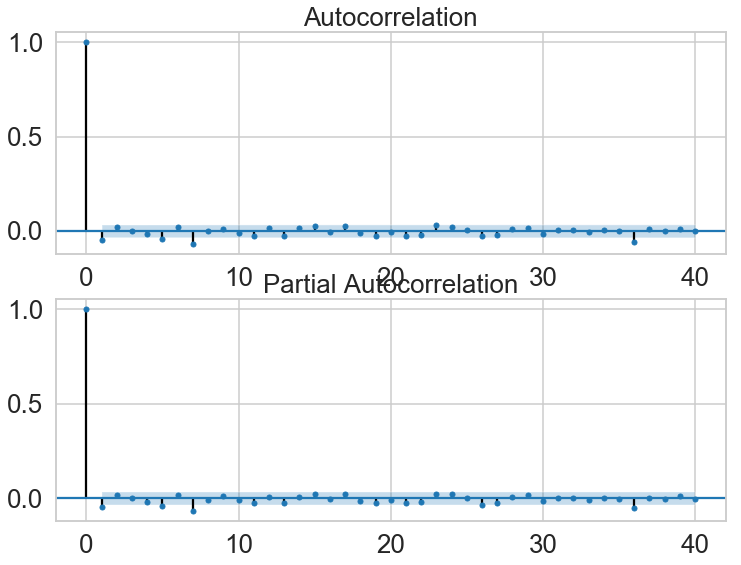

In [23]:
plot_acf_pacf(log_series_shift)

## 6. Prediction

In [31]:
sp_close_arima_df['log_series'] = log_series
sp_close_arima_df['log_series_shift'] = log_series_shift

********************
Iteration 1 of 4
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 2

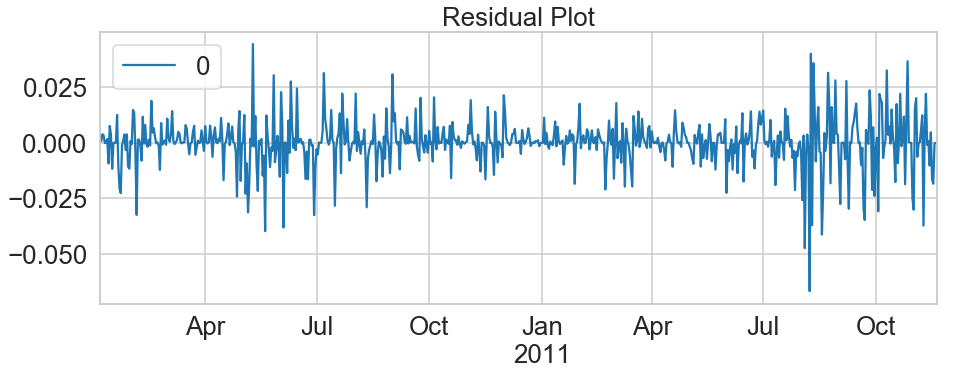

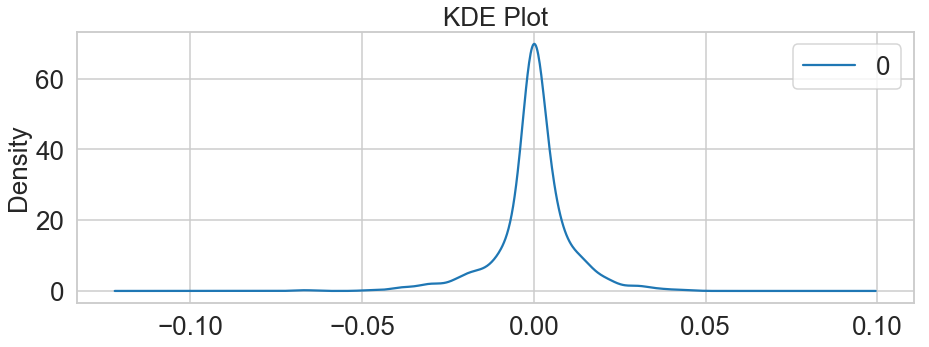

                  0
count  6.850000e+02
mean   4.605243e-07
std    1.074130e-02
min   -6.661690e-02
25%   -2.356790e-03
50%    9.103796e-05
75%    3.650958e-03
max    4.415506e-02


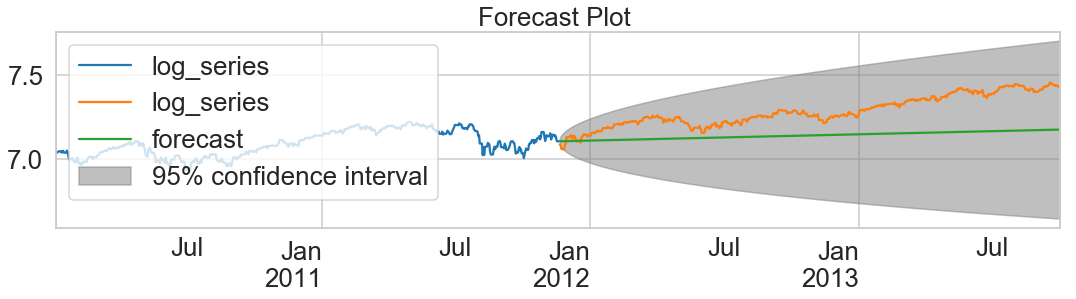

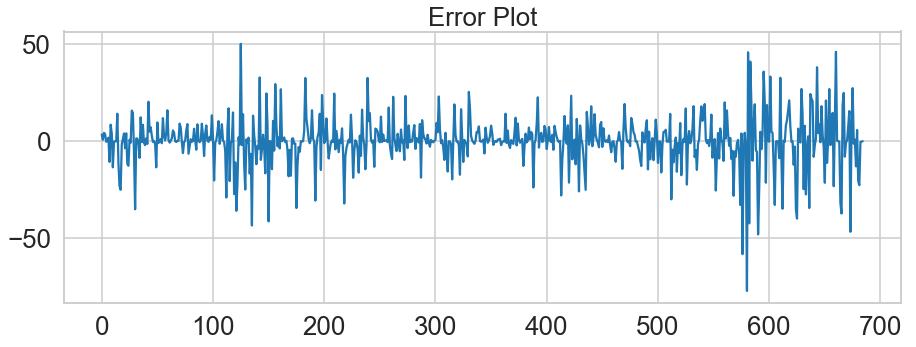

********************
Iteration 2 of 4
TRAIN: [   0    1    2 ... 1365 1366 1367] TEST: [1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381
 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395
 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407 1408 1409
 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423
 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437
 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451
 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465
 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479
 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493
 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507
 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521
 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535
 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 

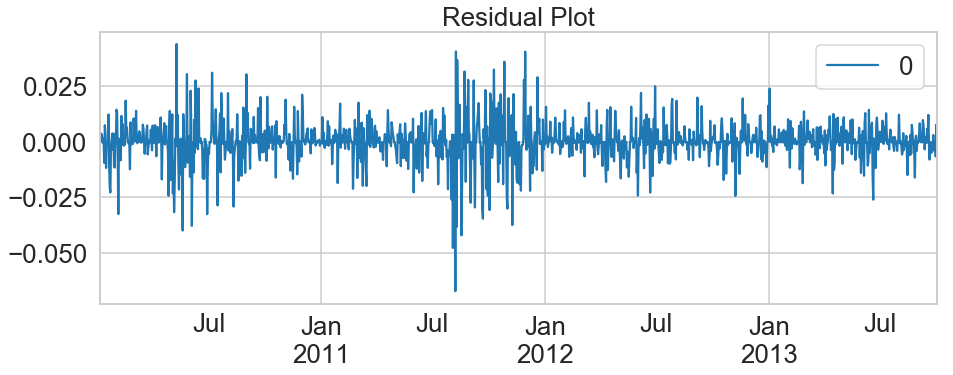

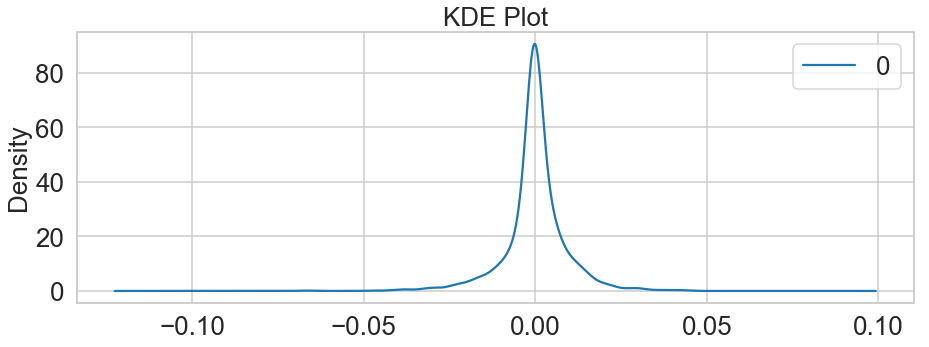

                  0
count  1.367000e+03
mean   1.882953e-07
std    9.013320e-03
min   -6.716009e-02
25%   -2.108579e-03
50%   -1.464599e-04
75%    3.054827e-03
max    4.377551e-02


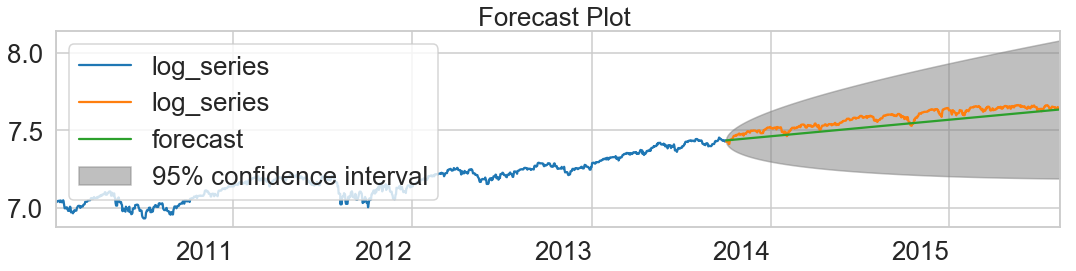

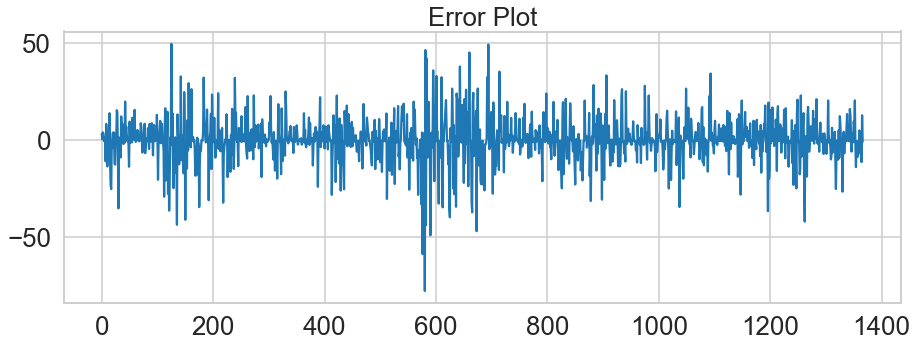

********************
Iteration 3 of 4
TRAIN: [   0    1    2 ... 2047 2048 2049] TEST: [2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105
 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119
 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133
 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147
 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161
 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175
 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189
 2190 2191 2192 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202 2203
 2204 2205 2206 2207 2208 2209 2210 2211 2212 2213 2214 2215 2216 2217
 2218 2219 2220 2221 2222 2223 2224 2225 2226 2227 2228 2229 

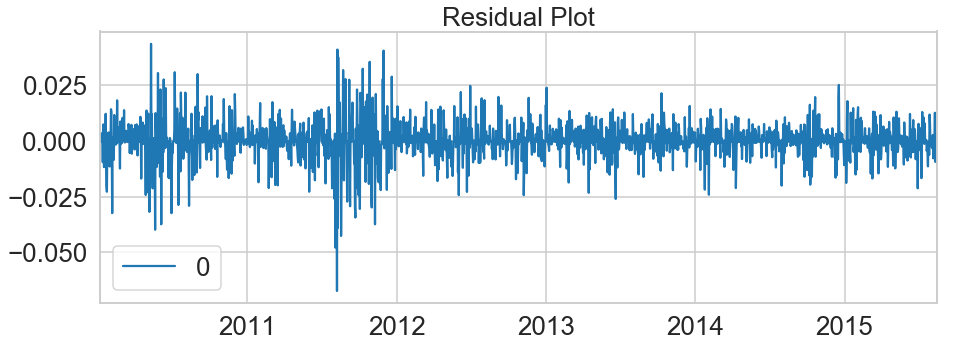

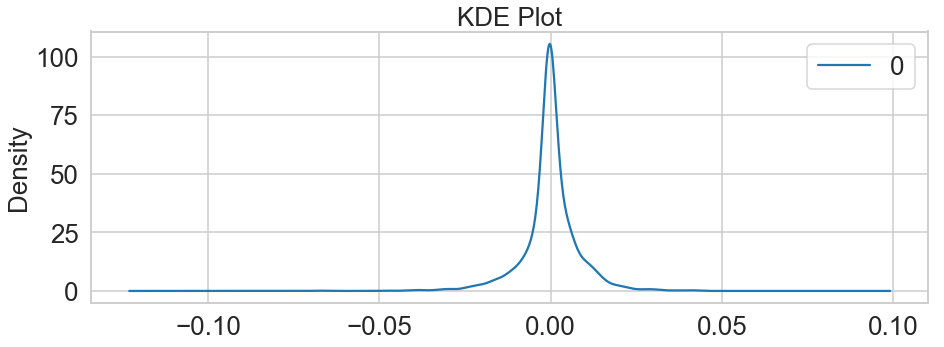

                  0
count  2.049000e+03
mean   1.088323e-07
std    8.135157e-03
min   -6.744544e-02
25%   -1.870689e-03
50%   -1.842954e-04
75%    2.872943e-03
max    4.361154e-02


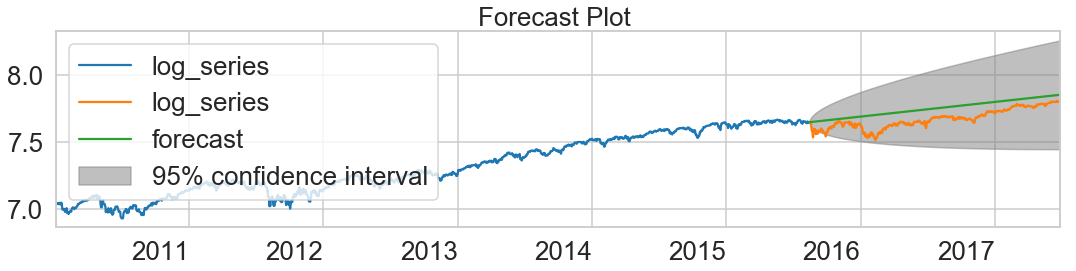

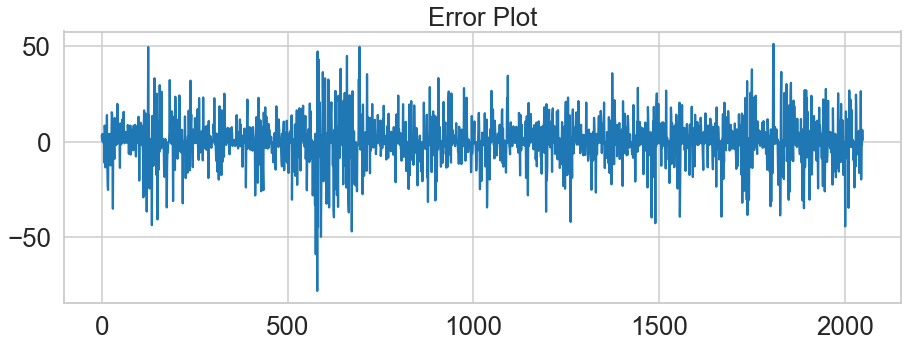

********************
Iteration 4 of 4
TRAIN: [   0    1    2 ... 2729 2730 2731] TEST: [2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743 2744 2745
 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757 2758 2759
 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771 2772 2773
 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785 2786 2787
 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799 2800 2801
 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813 2814 2815
 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827 2828 2829
 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841 2842 2843
 2844 2845 2846 2847 2848 2849 2850 2851 2852 2853 2854 2855 2856 2857
 2858 2859 2860 2861 2862 2863 2864 2865 2866 2867 2868 2869 2870 2871
 2872 2873 2874 2875 2876 2877 2878 2879 2880 2881 2882 2883 2884 2885
 2886 2887 2888 2889 2890 2891 2892 2893 2894 2895 2896 2897 2898 2899
 2900 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911 

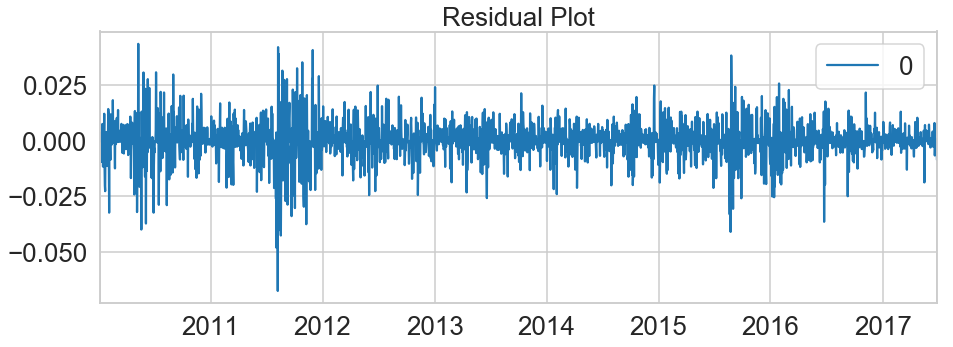

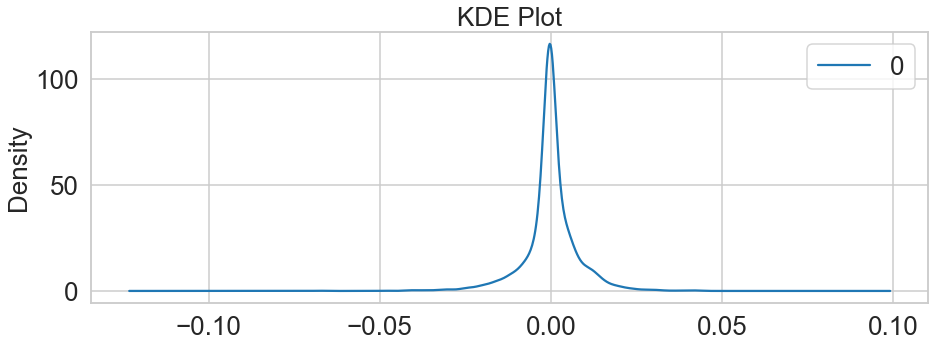

                  0
count  2.731000e+03
mean   7.476703e-08
std    7.899877e-03
min   -6.763677e-02
25%   -1.793093e-03
50%   -2.066623e-04
75%    2.550491e-03
max    4.360807e-02


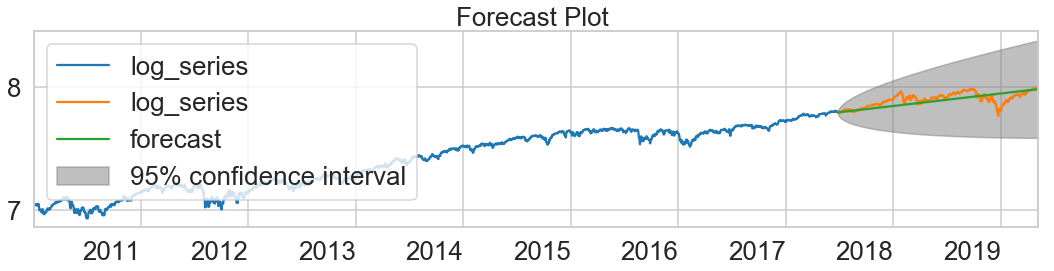

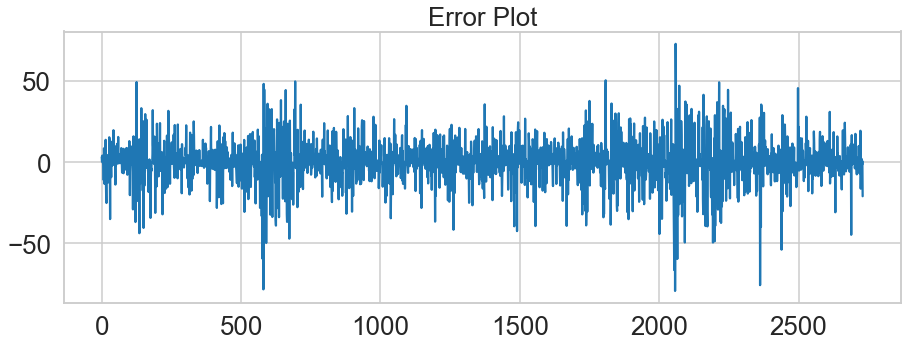

In [42]:
results_dict = arima_gridsearch_cv(sp_close_arima_df.log_series, cv_splits=4)

## References:

1. https://anomaly.io/seasonal-trend-decomposition-in-r/
2. https://www.investopedia.com/articles/active-trading/11/four-types-of-active-traders.asp
3. https://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/misc/TimeSeriesStockAnalysis.ipynb
4. http://people.duke.edu/~rnau/411home.htm
5. https://machinelearningmastery.com/time-series-data-stationary-python/